# 機械学習をPythonで実践する-16　　～ 欠損値対応-1 ～

In [1]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# # import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
# accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier


%matplotlib inline
import matplotlib.pyplot as plt


## ○ 欠損値の対応

In [2]:
# 元のCSVでは欠損値の表現がN/Aとなっているので、null_values='N/A'を指定しないと読み込みエラーになる。
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')

In [24]:
df.head()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
1,"""Wii Sports""","""Wii""",2006,"""Sports""","""Nintendo""",41.49,29.02,3.77,8.46,82.74
2,"""Super Mario Br...","""NES""",1985,"""Platform""","""Nintendo""",29.08,3.58,6.81,0.77,40.24
3,"""Mario Kart Wii...","""Wii""",2008,"""Racing""","""Nintendo""",15.85,12.88,3.79,3.31,35.82
4,"""Wii Sports Res...","""Wii""",2009,"""Sports""","""Nintendo""",15.75,11.01,3.28,2.96,33.0
5,"""Pokemon Red/Po...","""GB""",1996,"""Role-Playing""","""Nintendo""",11.27,8.89,10.22,1.0,31.37


In [25]:
# 欠損値の数を確認
df.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,58,0,0,0,0,0


Year（量的変数）とPublisher（カテゴリ変数）で欠損がある。

In [26]:
# 下記のように書くと、df.dtypes（リスト）の順序を保ったままユニークな値を取り出せる。
list(dict.fromkeys(df.dtypes))

[Int64, Utf8, Float64]

In [27]:
# 量的変数と質的変数のカラム名をそれぞれ取得
num_feat = df.select([pl.col(pl.Int64), pl.col(pl.Float64)]).columns
cat_feat = df.select(pl.col(pl.Utf8)).columns

### 対応１： カテゴリカラムの欠損を新たなカテゴリとして扱う

In [66]:
# 欠損値を"None"として埋めて、新たなカテゴリとして扱う。
df_new1 = df.with_columns(
    pl.col('Publisher').fill_null('None')
)

In [67]:
df_new1.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,0,0,0,0,0,0


In [72]:
df_new1.filter(pl.col('Publisher') == 'None')

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
471,"""wwe Smackdown ...","""PS2""",null,"""Fighting""","""None""",1.57,1.02,0.0,0.41,3.0
1305,"""Triple Play 99...","""PS""",null,"""Sports""","""None""",0.81,0.55,0.0,0.1,1.46
1664,"""Shrek / Shrek ...","""GBA""",2007,"""Misc""","""None""",0.87,0.32,0.0,0.02,1.21
2224,"""Bentley's Hack...","""GBA""",2005,"""Misc""","""None""",0.67,0.25,0.0,0.02,0.93
3161,"""Nicktoons Coll...","""GBA""",2004,"""Misc""","""None""",0.46,0.17,0.0,0.01,0.64
3168,"""SpongeBob Squa...","""GBA""",2004,"""Misc""","""None""",0.46,0.17,0.0,0.01,0.64
3768,"""SpongeBob Squa...","""GBA""",2004,"""Misc""","""None""",0.38,0.14,0.0,0.01,0.53
4147,"""Sonic the Hedg...","""PS3""",null,"""Platform""","""None""",0.0,0.48,0.0,0.0,0.48
4528,"""The Fairly Odd...","""GBA""",2004,"""Misc""","""None""",0.31,0.11,0.0,0.01,0.43


Publisherの欠損値を埋めることができた。  
EDAで見たようにPublisherには"Unknown"という欠損値のような項目が存在する。  
これを欠損値"None"と同じと見なすかどうか確認する。

In [80]:
# pl.concatで二つのデータフレームを結合
df_missing_pub = pl.concat([
    df_new1.filter(pl.col('Publisher') == 'None'),
    df_new1.filter(pl.col('Publisher') == 'Unknown')
]).to_pandas()
df_missing_pub

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,471,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,None,1.57,1.02,0.0,0.41,3.00
1,1305,Triple Play 99,PS,NaN,Sports,None,0.81,0.55,0.0,0.10,1.46
2,1664,Shrek / Shrek 2 2-in-1 Gameboy Advance Video,GBA,2007.0,Misc,None,0.87,0.32,0.0,0.02,1.21
3,2224,Bentley's Hackpack,GBA,2005.0,Misc,None,0.67,0.25,0.0,0.02,0.93
4,3161,Nicktoons Collection: Game Boy Advance Video V...,GBA,2004.0,Misc,None,0.46,0.17,0.0,0.01,0.64
...,...,...,...,...,...,...,...,...,...,...,...
256,16463,"Horse Life 4: My Horse, My Friend, My Champion",3DS,2015.0,Action,Unknown,0.00,0.01,0.0,0.00,0.01
257,16496,The Smurfs,3DS,NaN,Action,Unknown,0.00,0.01,0.0,0.00,0.01
258,16535,STORM: Frontline Nation,PC,2011.0,Strategy,Unknown,0.00,0.01,0.0,0.00,0.01
259,16548,The Treasures of Mystery Island 3 Pack - Save ...,PC,2011.0,Puzzle,Unknown,0.01,0.00,0.0,0.00,0.01


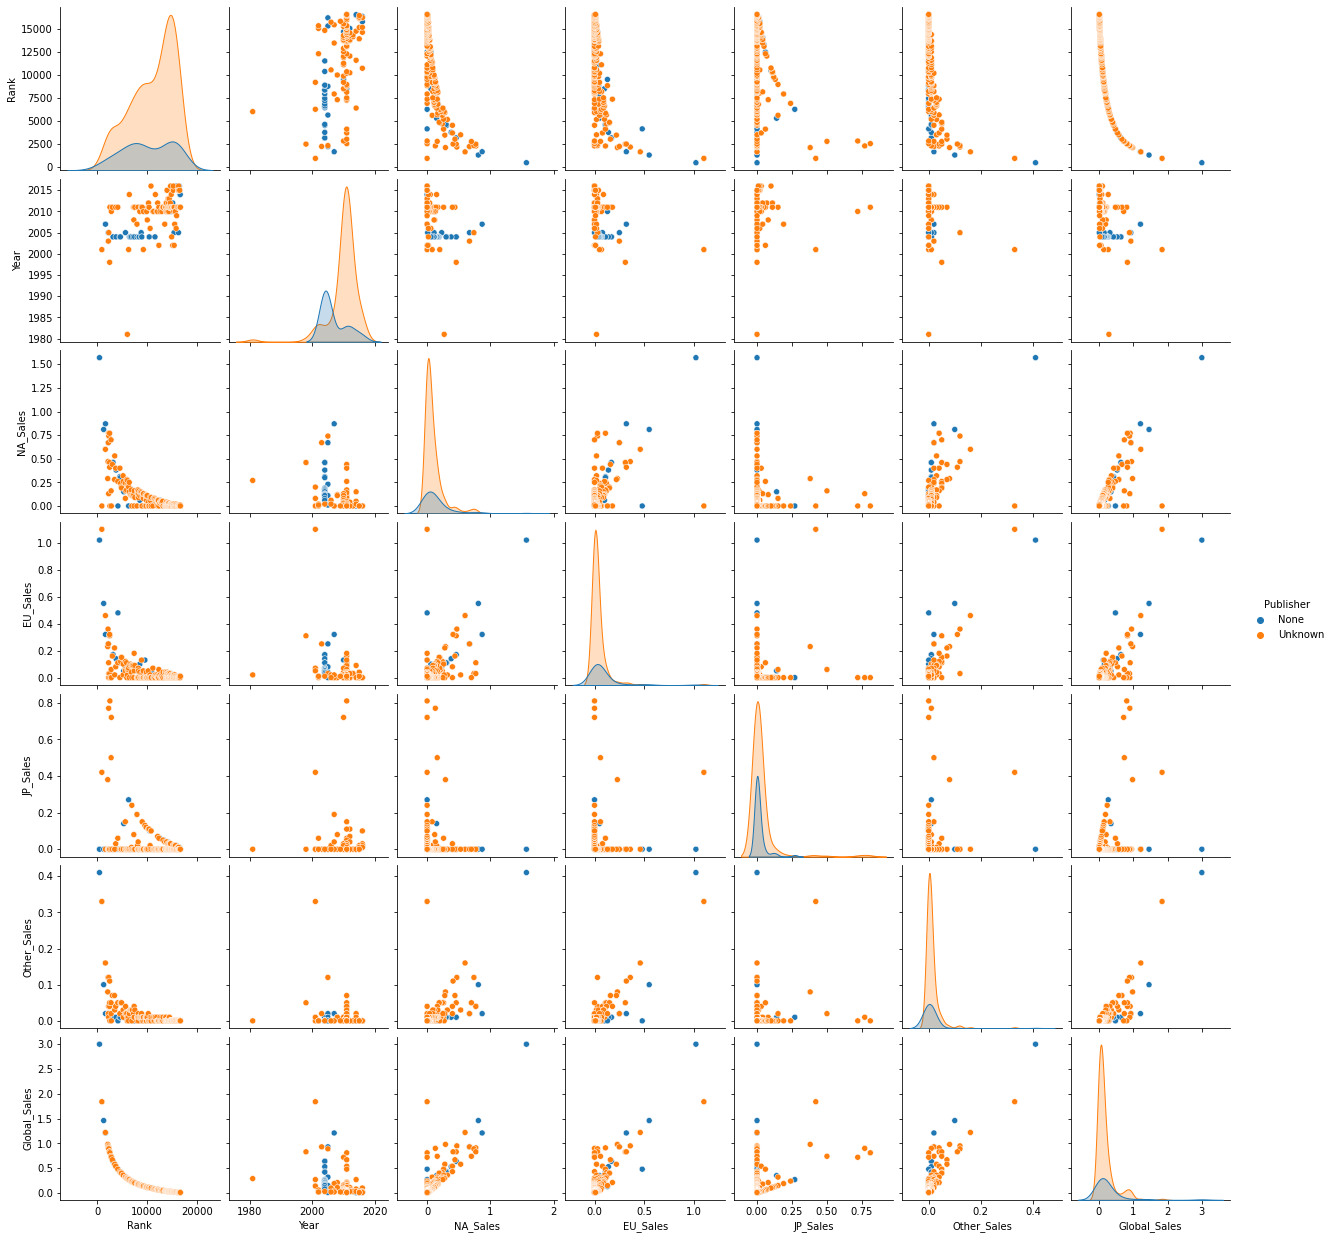

In [82]:
sns.pairplot(df_missing_pub, hue='Publisher')

Yearの列を見ると、NoneとUnknownでデータが顕著にわかれているので、  
Unknownは欠損値"None"と違うクラスと見なした方がよさそう。  
Noneは何かしらの理由である年でのPublisherの情報が抜けてしまったものと思われる。

### 対応2：欠損値に代表値を代入する
ここでは量的変数の欠損値には中央値を代入し、  
質的変数には最頻値を代入する。  
ここで注意すべきは中央値や最頻値を計算する際にテストデータは含んではいけないということ。  
(テストデータに対するカンニングになるため)  
なので学習データとテストデータに分けて、学習データの中央値・最頻値でテストデータも含めたデータ全体の欠損値を補完すること。  
ここでは手元にあるデータは学習データのみと考えて欠損値対応する。

In [92]:
df.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,58,0,0,0,0,0


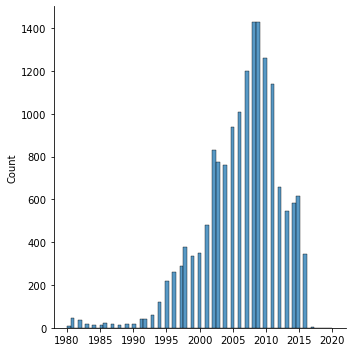

In [16]:
sns.displot(df['Year'])

In [17]:
df['Year'].median()

2007.0

In [31]:
len(df.filter(pl.col('Year') == 2007.0))

1202

In [55]:
# Yearの欠損値を中央値で埋める
df_new2 = df.with_columns(
    pl.col('Year').fill_null(pl.col('Year').median())
)

In [56]:
len(df_new2.filter(pl.col('Year') == 2007.0))

1473

In [57]:
df_new2.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,58,0,0,0,0,0


Yearの欠損値が0になり、2007.0の度数がその分（271）増えていることがわかる。

In [50]:
# Publisherの最頻値
df_new2['Publisher'].mode()

Publisher
str
"""Electronic Art..."


In [51]:
# 度数も確認
df_new2['Publisher'].value_counts().sort('counts', reverse=True).head(3)

Publisher,counts
str,u32
"""Electronic Art...",1351
"""Activision""",975
"""Namco Bandai G...",932


In [58]:
df_new2 = df_new2.with_columns(
    pl.col('Publisher').fill_null(pl.col('Publisher').mode())
)

In [61]:
df_new2.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


In [63]:
# 度数を再確認
df_new2['Publisher'].value_counts().sort('counts', reverse=True).head(3)

Publisher,counts
str,u32
"""Electronic Art...",1409
"""Activision""",975
"""Namco Bandai G...",932


想定通りに欠損値を埋められている。  
上記では分けて書いたが、Publisher, Yearのfill_nullはwith_columns内でまとめて書くことが可能。  
なお、ゲーム名がわかっているので最頻値で埋めるのは少々雑。実際はネット等で調べて埋める。  
また、YearもPlatform的にあり得ない(PS2とPSのソフトのYearが同じになっているなど)ので、  
PlatformごとのYearの中央値で埋めることを考えてみる。

### 対応3: より正確な欠損値対応

In [260]:
# PlatfromごとにYearに欠損値がある行をインデックス付きで抽出。with_row_countは行ごとに0から数字を振る。
miss_years = df.with_row_count().filter(pl.col('Year').is_null()).select(['row_nr','Platform','Year'])
miss_years


row_nr,Platform,Year
u32,str,i64
179,"""PS2""",null
377,"""PS2""",null
431,"""Wii""",null
470,"""PS2""",null
607,"""2600""",null
624,"""X360""",null
649,"""GBA""",null
652,"""Wii""",null
711,"""Wii""",null


仮にこれらのPlatformに対応するYearに一律に最頻値"2007.0"を入れると、  
年代的におかしい。PS3とPSのソフトが同じ年に発売されているとは考えにくい。  
よってPlatformごとのYearの中央値で欠損値を埋める。

In [264]:
# PlatformごとのYearの中央値を確認
platform_year_li = df.groupby('Platform').agg(pl.col('Year').median()).rows()
platform_year_li

[('PC', 2009.0),
 ('WiiU', 2013.0),
 ('GEN', 1993.0),
 ('PS2', 2005.0),
 ('PSP', 2009.0),
 ('PS3', 2011.0),
 ('XOne', 2015.0),
 ('WS', 2000.0),
 ('PCFX', 1996.0),
 ('SNES', 1994.0),
 ('DS', 2008.0),
 ('3DO', 1995.0),
 ('SCD', 1994.0),
 ('PS4', 2015.0),
 ('XB', 2004.0),
 ('Wii', 2009.0),
 ('GG', 1992.0),
 ('DC', 2000.0),
 ('SAT', 1996.0),
 ('NES', 1986.5),
 ('2600', 1982.0),
 ('GBA', 2003.0),
 ('3DS', 2013.0),
 ('GB', 1997.0),
 ('PSV', 2014.0),
 ('NG', 1994.5),
 ('TG16', 1995.0),
 ('PS', 1998.0),
 ('GC', 2003.0),
 ('X360', 2010.0),
 ('N64', 1999.0)]

.applyよりも速度的に有利なwhen,thenを使う。

In [228]:
# when,thenの.Exprのチェインを作る関数
def impute_miss_year(col:str, platform_year_li: list) -> pl.Expr:
    expr = pl
    # .Exprのチェイン
    for plat, year in platform_year_li:
        expr = expr.when( 
                (pl.col(col) == plat) & (pl.col('Year').is_null())
            ).then(year)
    
    # 条件以外について、元のYearそのままの値を使いたいならば、下記のようにそのままpl.colで書けばOK。
    expr = expr.otherwise(pl.col('Year'))
    return expr

In [233]:
# クエリのチェック
impute_miss_year(col, platform_year_li)

In [234]:
col = 'Platform'

df_new3 = df.with_columns(
    impute_miss_year(col, platform_year_li).alias('Year')
)#.filter(pl.col('Year').is_not_null())

In [235]:
df_new3.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,58,0,0,0,0,0


Yearの欠損が埋められたことが分かる。

元々Yearに欠損があった行を確認。  
Polarsでは基本的にインデックスを使用しないが、  
EDAにおいて細かくデータを見たいときのインデックスの有用性は否定していない。  
https://pola-rs.github.io/polars-book/user-guide/howcani/selecting_data/selecting_data_indexing.html

In [263]:
df_new3[miss_years[:, 0].to_list()]

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,f64,str,str,f64,f64,f64,f64,f64
180,"""Madden NFL 200...","""PS2""",2005.0,"""Sports""","""Electronic Art...",4.26,0.26,0.01,0.71,5.23
378,"""FIFA Soccer 20...","""PS2""",2005.0,"""Sports""","""Electronic Art...",0.59,2.36,0.04,0.51,3.49
432,"""LEGO Batman: T...","""Wii""",2009.0,"""Action""","""Warner Bros. I...",1.86,1.02,0.0,0.29,3.17
471,"""wwe Smackdown ...","""PS2""",2005.0,"""Fighting""",null,1.57,1.02,0.0,0.41,3.0
608,"""Space Invaders...","""2600""",1982.0,"""Shooter""","""Atari""",2.36,0.14,0.0,0.03,2.53
625,"""Rock Band""","""X360""",2010.0,"""Misc""","""Electronic Art...",1.93,0.34,0.0,0.21,2.48
650,"""Frogger's Adve...","""GBA""",2003.0,"""Adventure""","""Konami Digital...",2.15,0.18,0.0,0.07,2.39
653,"""LEGO Indiana J...","""Wii""",2009.0,"""Action""","""LucasArts""",1.54,0.63,0.0,0.22,2.39
713,"""Call of Duty 3...","""Wii""",2009.0,"""Shooter""","""Activision""",1.19,0.84,0.0,0.23,2.26


### 対応4: kNNを使って欠損値を予測する
対応1～2までの欠損値対応は手軽ではあるが、他の特徴量との関係性を考慮していないため、  
正確性に欠ける。そこで、欠損値を埋めたい特徴量を目的変数、他の特徴量を学習データとして機械学習モデルで欠損値を予測する。  
このモデルにはkNNが使われることがある模様。    
kNNを使って、Yearの欠損値を予測する。  
すなわち、Yearを目的変数、その他のカラムを特徴量として学習する。  
学習データは当然欠損値のない行であり、これを学習データとして欠損値を予測する。  

kNNを使った予測には下記の２通りある。  
・sklearn.neighbors.KNeighborsRegressorクラスでkNNを構築・予測  
・sklearn.impute.KNNImputer(n_neighbors)クラスで欠損値を埋める。  

今回は手元にあるデータが全て学習データとするが、  
もしテストデータも手元にある場合はkNNの学習にテストデータを含めないように注意。  


In [29]:
# 元のCSVでは欠損値の表現がN/Aとなっているので、null_values='N/A'を指定しないと読み込みエラーになる。
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')

In [30]:
# 学習の邪魔になるので、ここではPublisherの欠損値は適当に埋めておく。  
df = df.with_columns(
    pl.col('Publisher').fill_null('NaN')
)

In [31]:
df.head(1)

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
1,"""Wii Sports""","""Wii""",2006,"""Sports""","""Nintendo""",41.49,29.02,3.77,8.46,82.74


In [32]:
# Rank、NameはYearの予測には全く関係ないと思われるので落としておく。（でないとダミー変数が大量になってしまう。）
drop_list = ['Rank', 'Name']
df = df.drop(drop_list)

In [33]:
# ダミー変数に変換
df = df.to_dummies(cat_feat)

In [34]:
df.head(3)

Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,Platform_N64,Platform_NES,Platform_NG,Platform_PC,Platform_PCFX,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Year,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,...,Publisher_Wanadoo,Publisher_Warashi,Publisher_Wargaming.net,Publisher_Warner Bros. Interactive Entertainment,Publisher_Warp,Publisher_WayForward Technologies,Publisher_Westwood Studios,Publisher_White Park Bay Software,Publisher_Wizard Video Games,Publisher_XS Games,Publisher_Xicat Interactive,Publisher_Xing Entertainment,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yamasa Entertainment,Publisher_Yeti,Publisher_Yuke's,Publisher_Yumedia,Publisher_Zenrin,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i64,u8,u8,u8,u8,u8,...,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,f64,f64,f64,f64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2006,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41.49,29.02,3.77,8.46,82.74
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1985,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.08,3.58,6.81,0.77,40.24
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2008,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.85,12.88,3.79,3.31,35.82


！！注意！！  
データをkNNの学習データと欠損値予測対象のデータに分ける前にダミー変数に変換する必要がある。  
どちらか片方のデータにしかないクラスがある場合、特徴量の数が合わなくなるため。  
また、Polarsのto_dummiesにはPandasのdrop_firstに相当するパラメタはないので、  
線形モデルを使うのであれば（多重共線性を気にするのであれば）、一度Pandas DFに変換してpd.get_dummiesを使うか、  
それぞれのカテゴリカラムから一列ずつ落とすこと。  



In [35]:
# 欠損値予測用の特徴量とその目的変数を格納。これがkNNの学習データになる。
target = 'Year'
X_train_for_miss = df.filter(pl.col(target).is_not_null()).drop(target).to_pandas()
y_train_for_miss = df.filter(pl.col(target).is_not_null()).get_column(target).to_pandas()

# 欠損値のある行のYear以外のカラム
X_miss_year = df.filter(pl.col(target).is_null()).drop(target).to_pandas()

scikit-learnのクラスのメソッドはPolars DFを受け取れない場合があるので、  
Pandas DFに変換している。  
後々indexを使うので、ここでnullのindexを取得しておき、それでスライシングしてもよいかも。

In [36]:
num_feat2 = num_feat.copy()
#量的変数のリストから目的変数を削除
num_feat2.remove('Year')
num_feat2.remove('Rank')

# 学習データの特徴量スケーリング。予測に使うX_miss_yearの標準化の際はfitしてはいけないことに注意。
scaler = StandardScaler()
X_train_for_miss[num_feat2] = scaler.fit_transform(X_train_for_miss[num_feat2])
X_miss_year[num_feat2] = scaler.transform(X_miss_year[num_feat2])

In [37]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train_for_miss, y_train_for_miss)

KNeighborsRegressor(n_neighbors=3)

In [38]:
# 欠損値に対する予測
miss_year_pred = model.predict(X_miss_year)
miss_year_pred[:10]

array([2004.33333333, 2005.        , 2008.66666667, 2003.33333333,
       1980.66666667, 2009.33333333, 1997.66666667, 2009.        ,
       2009.        , 2009.        ])

In [39]:
# int型にキャスト。年なので小数点以下は切り捨てとする。
miss_year_pred = miss_year_pred.astype(int)
miss_year_pred[:10]

array([2004, 2005, 2008, 2003, 1980, 2009, 1997, 2009, 2009, 2009])

In [87]:
# 元のdfに予測結果を入れるために読み直す
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')

In [41]:
# 欠損値があった行のindexを取得
miss_year_idx = df.with_row_count().filter(pl.col('Year').is_null()).get_column('row_nr').to_numpy() 
miss_year_idx[:5]

array([179, 377, 431, 470, 607], dtype=uint32)

In [42]:
# 予測に使ったデータのインデックスと合っているか確認。　※X_miss_yearへの代入値のインデックスを確認している。
df.with_row_count().filter(pl.col('Year').is_null()).head(5)

row_nr,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,i64,str,str,i64,str,str,f64,f64,f64,f64,f64
179,180,"""Madden NFL 200...","""PS2""",null,"""Sports""","""Electronic Art...",4.26,0.26,0.01,0.71,5.23
377,378,"""FIFA Soccer 20...","""PS2""",null,"""Sports""","""Electronic Art...",0.59,2.36,0.04,0.51,3.49
431,432,"""LEGO Batman: T...","""Wii""",null,"""Action""","""Warner Bros. I...",1.86,1.02,0.0,0.29,3.17
470,471,"""wwe Smackdown ...","""PS2""",null,"""Fighting""",null,1.57,1.02,0.0,0.41,3.0
607,608,"""Space Invaders...","""2600""",null,"""Shooter""","""Atari""",2.36,0.14,0.0,0.03,2.53


学習データのインデックス(=予測結果が入るべきインデックス)とmiss_year_idxが同じことが  
確認できたので、予測値で欠損値を埋める。

In [43]:
miss_year_preds_li = list(zip(miss_year_idx, miss_year_pred))
miss_year_preds_li[:5]

[(179, 2004), (377, 2005), (431, 2008), (470, 2003), (607, 1980)]

In [44]:
col = 'row_nr'

# yearの欠損値を埋めるためにwhen,thenの.Exprのチェインを作る関数
def impute_miss_year_with_pred(col:str, miss_year_preds_li: list) -> pl.Expr:
    expr = pl
    # .Exprのチェイン
    for miss_idx, year_pred in miss_year_preds_li:
        expr = expr.when( 
                (pl.col(col) == miss_idx) & (pl.col('Year').is_null())
            ).then(pl.lit(year_pred))
    
    # 条件以外について、元のYearそのままの値を使いたいならば、下記のようにそのままpl.colで書けばOK。
    expr = expr.otherwise(pl.col('Year'))
    return expr

year_predが整数の場合、pl.litを付けないとエラーになる。  
floatならば何も言われない。

In [616]:
# クエリのチェック
#impute_miss_year_with_pred(col, miss_year_preds_li)

In [117]:
df_new4 = df.with_row_count().with_columns(
    impute_miss_year_with_pred(col, miss_year_preds_li).alias('Year')
)#.filter(pl.col('Year').is_not_null())

In [118]:
miss_year_pred[:10]

array([2004, 2005, 2008, 2003, 1980, 2009, 1997, 2009, 2009, 2009])

In [119]:
df_new4[miss_year_idx].head(10)

row_nr,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,i64,str,str,i64,str,str,f64,f64,f64,f64,f64
179,180,"""Madden NFL 200...","""PS2""",2004,"""Sports""","""Electronic Art...",4.26,0.26,0.01,0.71,5.23
377,378,"""FIFA Soccer 20...","""PS2""",2005,"""Sports""","""Electronic Art...",0.59,2.36,0.04,0.51,3.49
431,432,"""LEGO Batman: T...","""Wii""",2008,"""Action""","""Warner Bros. I...",1.86,1.02,0.0,0.29,3.17
470,471,"""wwe Smackdown ...","""PS2""",2003,"""Fighting""",null,1.57,1.02,0.0,0.41,3.0
607,608,"""Space Invaders...","""2600""",1980,"""Shooter""","""Atari""",2.36,0.14,0.0,0.03,2.53
624,625,"""Rock Band""","""X360""",2009,"""Misc""","""Electronic Art...",1.93,0.34,0.0,0.21,2.48
649,650,"""Frogger's Adve...","""GBA""",1997,"""Adventure""","""Konami Digital...",2.15,0.18,0.0,0.07,2.39
652,653,"""LEGO Indiana J...","""Wii""",2009,"""Action""","""LucasArts""",1.54,0.63,0.0,0.22,2.39
711,713,"""Call of Duty 3...","""Wii""",2009,"""Shooter""","""Activision""",1.19,0.84,0.0,0.23,2.26


In [48]:
df.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,58,0,0,0,0,0


In [49]:
df_new4.null_count()

row_nr,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,58,0,0,0,0,0


ちゃんと予測値が入っている。

#### （補足）kNNが欠損値の予測に使った点を見てみる

In [106]:
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')
df.to_pandas().iloc[miss_year_idx].head(1)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
179,180,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23


In [123]:
# 以下のようにすると、idx=179の欠損値が学習データのどの点から予測されたのか見ることができる。
# idx=179（df全体のインデックス的に一番最初の欠損値）はX_miss_yearの1行目に対応していることに注意。
neighbors = model.kneighbors(X_miss_year.head(1))
neighbors

(array([[0.47672405, 1.04418233, 1.52264237]]), array([[210, 239, 278]]))

In [122]:
X_train_for_miss.loc[neighbors[1][0]]

,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,...,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.521349,0.221023,-0.220387,3.221381,2.790965
239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.095333,0.181711,-0.220387,2.958056,2.522711
278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.766692,0.122743,-0.220387,2.694731,2.299167


カテゴリカル変数が似ているのかは判断できないが、  
Sales系のカラムは近しい値が入っているので、5つあるSales系のカラムが距離に大きく寄与している可能性が高い。  
Salesはあまり発売年Yearに関係ないと予想されるので、カラムは1つ程度で良いかもしれない。

In [115]:
y_train_for_miss.loc[neighbors[1][0]]

210    2005
239    2006
278    2002
Name: Year, dtype: int64

In [116]:
(2005 + 2006 + 2002)/3

2004.3333333333333

In [121]:
df_new4[miss_year_idx].head(1)

row_nr,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,i64,str,str,i64,str,str,f64,f64,f64,f64,f64
179,180,"""Madden NFL 200...","""PS2""",2004,"""Sports""","""Electronic Art...",4.26,0.26,0.01,0.71,5.23


確かに上記の３点のYearの平均値から求められていることが分かる。

### 対応4.5： KNNImputerで欠損値を埋める
scikit-learnのKNNInputerを使えば対応4の作業を数行で実行できる。

In [3]:
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')

In [126]:
# 事前にダミー変数への変換と標準化はしておく必要あり。
drop_list = ['Rank', 'Name']
df = pd.get_dummies(df.drop(drop_list).to_pandas(), drop_first=True)

num_feat2 = num_feat.copy()
#量的変数のリストから目的変数を削除
num_feat2.remove('Year')
num_feat2.remove('Rank')

scaler = StandardScaler()
df[num_feat2] = scaler.fit_transform(df[num_feat2])

In [127]:
df

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
0,2006.0,50.480508,57.136930,11.938058,44.606085,52.864025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1985.0,35.284437,6.794188,21.767296,3.828224,25.532503,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008.0,19.084273,25.197785,12.002724,17.297115,22.690025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2009.0,18.961823,21.497277,10.353740,15.441165,20.876498,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1996.0,13.476053,17.302048,32.792857,5.047848,19.828254,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16593,2002.0,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16594,2003.0,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16595,2008.0,-0.324086,-0.290207,-0.251492,-0.254864,-0.339194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16596,2010.0,-0.324086,-0.270418,-0.251492,-0.254864,-0.339194,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [128]:
miss_index = df[df['Year'].isna()].index
df.iloc[miss_index]

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
179,NaN,4.892293,0.224302,-0.219159,3.510062,3.017760,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,NaN,0.398370,4.379953,-0.122160,2.449519,1.898775,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
431,NaN,1.953488,1.728252,-0.251492,1.282922,1.692985,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
470,NaN,1.598383,1.728252,-0.251492,1.919248,1.583659,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607,NaN,2.565739,-0.013164,-0.251492,-0.095783,1.281404,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,NaN,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16327,NaN,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16366,NaN,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16427,NaN,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
%%time
imputer = KNNImputer(n_neighbors=3)
# transformの戻り値をpandas df形式で受け取る。デフォルトではnumpy
# fitやtransformを持っているクラスには基本的にこのようなset_outputがあるので覚えておくとよい
imputer.set_output(transform='pandas')
df_imputed = imputer.fit_transform(df)

CPU times: user 11.1 s, sys: 392 ms, total: 11.5 s
Wall time: 9.14 s


In [131]:
df_imputed.iloc[miss_index]

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
179,2004.333333,4.892293,0.224302,-0.219159,3.510062,3.017760,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377,2005.000000,0.398370,4.379953,-0.122160,2.449519,1.898775,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,2008.666667,1.953488,1.728252,-0.251492,1.282922,1.692985,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,2003.333333,1.598383,1.728252,-0.251492,1.919248,1.583659,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,1980.666667,2.565739,-0.013164,-0.251492,-0.095783,1.281404,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,2003.000000,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16327,2010.333333,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16366,2011.333333,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16427,2009.000000,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# 対応4の結果と比較。
miss_year_pred[:10]

array([2004, 2005, 2008, 2003, 1980, 2009, 1997, 2009, 2009, 2009])

Yearの欠損値が埋まっていることが分かる。（対応4での予測値と同じ）  
コーディング量はKNNImputerを使った方が少なくて楽だが、実行速度的には対応4のように人力で書いた方が早そう。  
欠損値がある行に代入していくのに時間がかかっているのかも？  
Polarsはwhen,thenを使っているから早いとか。  

aaa
